In [1]:
# Open and Inspect File
import xarray as xr

fn = "C:/Users/jenna/OneDrive/Desktop/Fall 2025/Energy Meterology/Final Proj/data/Historical_NearSurface_CMIP_City.nc"

# lazy open (good default)
ds = xr.open_dataset(fn)

# quick overview
print(ds)
print("Variables:", list(ds.data_vars))
print("Coords:", ds.coords)
print(ds.tas.attrs)        # check units, long_name, etc.


<xarray.Dataset>
Dimensions:  (time: 5840)
Coordinates:
  * time     (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2014-12-31
Data variables:
    lat      (time) float64 ...
    lon      (time) float64 ...
    tas      (time) float32 ...
    year     (time) int32 ...
    tas_C    (time) float32 ...
Variables: ['lat', 'lon', 'tas', 'year', 'tas_C']
Coords: Coordinates:
  * time     (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2014-12-31
{}


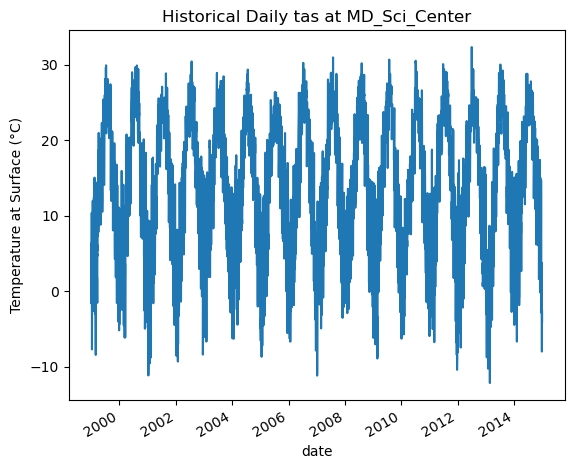

In [4]:
import matplotlib.pyplot as plt
ts = ds.tas_C.sel()
ts = ts.sel()

ts.plot.line(x='time')
plt.ylabel("Temperature at Surface (°C)")
plt.xlabel("date")
plt.title("Historical Daily tas at MD_Sci_Center")
plt.show()

In [5]:
import pandas as pd
# Load the dataset
fn2 = "C:/Users/jenna/OneDrive/Desktop/Fall 2025/Energy Meterology/Final Proj/data/City_Hist_Data.csv"
df = pd.read_csv(fn2)

# Inspect the data
print(df.head())
print(df.info())

       STATION       DATE      TIME   NAME  TAVG  TMAX  TMIN
0  74594493784  1/14/1999  23:59:00  SOD    32.0  36.0  27.0
1  74594493784  1/15/1999  23:59:00  SOD    33.0  38.0  28.0
2  74594493784  1/16/1999  23:59:00  SOD    40.0  53.0  27.0
3  74594493784  1/17/1999  23:59:00  SOD    47.0  56.0  38.0
4  74594493784  1/18/1999  23:59:00  SOD    49.0  58.0  39.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6486 entries, 0 to 6485
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   STATION  6486 non-null   int64  
 1   DATE     6486 non-null   object 
 2   TIME     6486 non-null   object 
 3   NAME     6486 non-null   object 
 4   TAVG     6426 non-null   float64
 5   TMAX     6428 non-null   float64
 6   TMIN     6426 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 354.8+ KB
None


In [6]:
df['DATE'] = pd.to_datetime(df['DATE'])
df_cleaned = df.dropna(subset=['TAVG']).copy()

# Filter and convert to Celsius (C = (F - 32) * 5/9)
start_date = '1999-01-01'
end_date = '2014-12-31'
df_filtered = df_cleaned[(df_cleaned['DATE'] >= start_date) & (df_cleaned['DATE'] <= end_date)].copy()
df_filtered['TAVG_C'] = (df_filtered['TAVG'] - 32) * 5/9
df_filtered['DATE'] = pd.to_datetime(df_filtered['DATE'])

print(df_filtered)

          STATION       DATE      TIME   NAME  TAVG  TMAX  TMIN     TAVG_C
0     74594493784 1999-01-14  23:59:00  SOD    32.0  36.0  27.0   0.000000
1     74594493784 1999-01-15  23:59:00  SOD    33.0  38.0  28.0   0.555556
2     74594493784 1999-01-16  23:59:00  SOD    40.0  53.0  27.0   4.444444
3     74594493784 1999-01-17  23:59:00  SOD    47.0  56.0  38.0   8.333333
4     74594493784 1999-01-18  23:59:00  SOD    49.0  58.0  39.0   9.444444
...           ...        ...       ...    ...   ...   ...   ...        ...
5736  74594493784 2014-12-27  23:59:00  SOD    47.0  56.0  37.0   8.333333
5737  74594493784 2014-12-28  23:59:00  SOD    51.0  59.0  42.0  10.555556
5738  74594493784 2014-12-29  23:59:00  SOD    43.0  46.0  40.0   6.111111
5739  74594493784 2014-12-30  23:59:00  SOD    37.0  40.0  33.0   2.777778
5740  74594493784 2014-12-31  23:59:00  SOD    32.0  35.0  28.0   0.000000

[5685 rows x 8 columns]


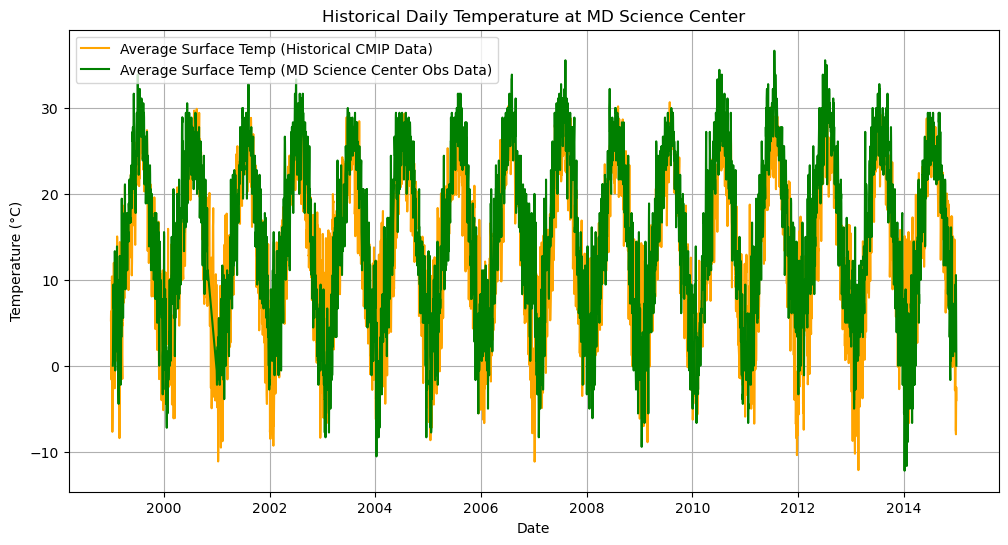

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import cftime

# Convert df_filtered DATE to datetime
df_filtered['DATE'] = pd.to_datetime(df_filtered['DATE'])

# Convert cftime.DatetimeNoLeap to matplotlib numeric dates
ts_time_nums = mdates.date2num([pd.Timestamp(str(t)) for t in ts['time'].values])

fig, ax = plt.subplots(figsize=(12,6))

# Plot ts
ax.plot(ts_time_nums, ts.values, color='orange', label='Average Surface Temp (Historical CMIP Data)')

# Plot df_filtered
ax.plot(df_filtered['DATE'], df_filtered['TAVG_C'], color='g', label='Average Surface Temp (MD Science Center Obs Data)')

# Format x-axis as dates
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.YearLocator(2))  # tick every 2 years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax.set_xlabel("Date")
ax.set_ylabel("Temperature (°C)")
ax.set_title("Historical Daily Temperature at MD Science Center")
ax.legend()
ax.grid(True)

plt.show()

In [8]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# ts dates as just date
ts_df = pd.DataFrame({
    'DATE': [pd.Timestamp(str(t)).date() for t in ts['time'].values],
    'tas_C': ts.values
})

# df_filtered dates as just date
df_filtered['DATE_ONLY'] = df_filtered['DATE'].dt.date

# Merge on just the date
merged = pd.merge(ts_df, df_filtered[['DATE_ONLY', 'TAVG_C']], 
                  left_on='DATE', right_on='DATE_ONLY', how='inner')

# Now calculate correlation
from scipy.stats import pearsonr

r, p_value = pearsonr(merged['tas_C'], merged['TAVG_C'])
print(f"Pearson r: {r:.4f}")
print(f"P-value: {p_value:.4e}")

Pearson r: 0.7906
P-value: 0.0000e+00
